## Evaluating Machine Learning for News Article Classification: Metrics, Insights, and Best Practices

In [1]:
#!pip install requests beautifulsoup4 pandas


In [22]:
#!pip install newsapi-python

In [23]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
import time
import random
from newsapi import NewsApiClient

#### Web Scrapping Using NewsApi

In [26]:
# Replace 'your_api_key_here' with your actual News API key
API_KEY = '*****'
newsapi = NewsApiClient(api_key=API_KEY)
def fetch_news(query, page_size=100, max_pages=1):
    """
    Fetch news articles from the API with pagination support.
    """
    all_articles = []
    for page in range(1, max_pages + 1):
        try:
            response = newsapi.get_everything(
                q=query,
                language='en',
                sort_by='relevancy',
                page=page,
                page_size=page_size
            )
            articles = response.get('articles', [])
            if not articles:
                print(f"No articles found for query: {query}, Page: {page}")
                break
            all_articles.extend(articles)
            print(f"Fetched {len(articles)} articles for query: {query}, Page: {page}")
            time.sleep(1)  # Sleep to avoid hitting API rate limits
        except Exception as e:
            print(f"Error fetching data for query: {query}, Page: {page}")
            print(e)
            time.sleep(60)  # Wait before retrying on error
    return pd.DataFrame(all_articles)

def save_to_csv(df, file_path):
    """
    Save DataFrame to CSV, appending new data and removing duplicates.
    """
    if os.path.exists(file_path):
        # Load existing data
        existing_df = pd.read_csv(file_path)
        # Combine with new data
        combined_df = pd.concat([existing_df, df], ignore_index=True)
        # Drop duplicates based on 'url'
        combined_df = combined_df.drop_duplicates(subset='url')
    else:
        # Save new data
        combined_df = df

    # Save to CSV
    combined_df.to_csv(file_path, index=False)

# Define queries and the number of pages to fetch
queries = ['technology', 'politics', 'sports', 'economy']
csv_file_path = 'news_articles.csv'  # Path to the CSV file

# Collect articles from multiple queries and save to CSV
df_list = []
for query in queries:
    df = fetch_news(query, page_size=100, max_pages=1)  # Adjust max_pages as needed
    df_list.append(df)

# Concatenate all dataframes into one
df = pd.concat(df_list, ignore_index=True)

# Prepare data for saving
df = df[['title', 'description', 'content', 'publishedAt', 'source', 'url']]
df['text'] = df['title'].fillna('') + " " + df['description'].fillna('') + " " + df['content'].fillna('')

# Save to CSV
save_to_csv(df, csv_file_path)

print(f"Data saved to {csv_file_path}")
print(f"Total articles collected and saved: {df.shape[0]}")
print(df.head())

Fetched 100 articles for query: technology, Page: 1
Fetched 100 articles for query: politics, Page: 1
Fetched 100 articles for query: sports, Page: 1
Fetched 100 articles for query: economy, Page: 1
Data saved to news_articles.csv
Total articles collected and saved: 400
                                               title  \
0  You Won’t Believe What Car Headlights Have in ...   
1  NASA’s Quantum Cold Atom Lab Just Made Space E...   
2  Technology Softens a Poignant Farewell in This...   
3  In This Exclusive Evil Clip, AI Bedevils a Pri...   
4  America’s Cyber Security Agency Picks Its Firs...   

                                         description  \
0  New technology and a drive toward electrified ...   
1  Using quantum technology in space could help s...   
2  Take a reading break with "The Last Lucid Day"...   
3  Wallace Shawn's Father Ignatius tangles with t...   
4  The pick comes at a time when CISA’s head has ...   

                                             content   

### Data preprocessing

1. Loading the Data
Assuming you have the CSV file with news data, we'll load it into a DataFrame.

In [29]:
import pandas as pd

# Load the data
file_path = 'news_articles.csv'
df = pd.read_csv(file_path)

# Display basic information about the data
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        400 non-null    object
 1   description  398 non-null    object
 2   content      399 non-null    object
 3   publishedAt  400 non-null    object
 4   source       400 non-null    object
 5   url          400 non-null    object
 6   text         400 non-null    object
dtypes: object(7)
memory usage: 22.0+ KB
None
                                               title  \
0  You Won’t Believe What Car Headlights Have in ...   
1  NASA’s Quantum Cold Atom Lab Just Made Space E...   
2  Technology Softens a Poignant Farewell in This...   
3  In This Exclusive Evil Clip, AI Bedevils a Pri...   
4  America’s Cyber Security Agency Picks Its Firs...   

                                         description  \
0  New technology and a drive toward electrified ...   
1  Using quantum technology in s

2. Text Cleaning and Transformation
Cleaning the text data involves:

- Removing unnecessary characters
- Removing stop words
- Removing punctuation

In [31]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stop words
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lower case
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    # Join words back to string
    text = ' '.join(words)
    return text

# Apply cleaning to text columns
df['title'] = df['title'].apply(clean_text)
df['description'] = df['description'].apply(clean_text)
df['content'] = df['content'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


3. Handling Missing Values
Handle missing values in the DataFrame. You can either fill them with placeholders or drop rows with missing values.

In [32]:
# Fill missing values with empty strings
df['title'].fillna('', inplace=True)
df['description'].fillna('', inplace=True)
df['content'].fillna('', inplace=True)

# Alternatively, you could drop rows with missing values:
# df.dropna(subset=['title', 'description', 'content'], inplace=True)


4. Text Normalization
Normalization typically involves lemmatization or stemming. Here, we'll use lemmatization from NLTK.

In [34]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Apply lemmatization
df['title'] = df['title'].apply(lemmatize_text)
df['description'] = df['description'].apply(lemmatize_text)
df['content'] = df['content'].apply(lemmatize_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...


5. Data Transformation
Combine the text fields into one consolidated text field if required.

In [35]:
# Combine text fields into one
df['text'] = df['title'] + " " + df['description'] + " " + df['content']

# Select relevant columns for the final DataFrame
df_final = df[['title', 'description', 'content', 'publishedAt', 'source', 'url', 'text']]


Saving the Preprocessed Data
Finally, save the preprocessed data back to a CSV file.

In [36]:
preprocessed_file_path = 'preprocessed_news_articles.csv'
df_final.to_csv(preprocessed_file_path, index=False)

print(f"Preprocessed data saved to {preprocessed_file_path}")
print(f"Total articles after preprocessing: {df_final.shape[0]}")
print(df_final.head())


Preprocessed data saved to preprocessed_news_articles.csv
Total articles after preprocessing: 400
                                               title  \
0                   wont believe car headlight store   
1  nasa quantum cold atom lab made space even coo...   
2  technology softens poignant farewell scifi sho...   
3  exclusive evil clip ai bedevils priest beyond ...   
4   america cyber security agency pick first head ai   

                                         description  \
0  new technology drive toward electrified powert...   
1  using quantum technology space could help scie...   
2  take reading break last lucid day dominique di...   
3  wallace shawn father ignatius tangle technolog...   
4  pick come time cisas head compared new technol...   

                                             content           publishedAt  \
0  sure duh vehicle light serve important vital s...  2024-08-02T11:00:00Z   
1  nasa experimenting use quantum technology meas...  2024-08-14T10:00:5

1. Text Summarization Models

1.1 Extractive Summarization (TextRank)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def textrank_summarization(text, num_sentences=3):
    # Tokenize sentences
    sentences = text.split('. ')

    # Vectorize sentences
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(sentences)

    # Compute cosine similarity matrix
    sim_matrix = cosine_similarity(X, X)

    # Compute scores for each sentence
    scores = sim_matrix.sum(axis=1)

    # Get the top sentences
    ranked_sentences = [sentences[i] for i in np.argsort(scores, axis=0)[-num_sentences:]]

    return '. '.join(ranked_sentences)

# Example usage
df['summary'] = df['text'].apply(lambda x: textrank_summarization(x))
print(df[['title', 'summary']].head())


                                               title  \
0                   wont believe car headlight store   
1  nasa quantum cold atom lab made space even coo...   
2  technology softens poignant farewell scifi sho...   
3  exclusive evil clip ai bedevils priest beyond ...   
4   america cyber security agency pick first head ai   

                                             summary  
0  wont believe car headlight store new technolog...  
1  nasa quantum cold atom lab made space even coo...  
2  technology softens poignant farewell scifi sho...  
3  exclusive evil clip ai bedevils priest beyond ...  
4  america cyber security agency pick first head ...  


b. Abstractive Summarization (Using Hugging Face Transformers)

In [42]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Initialize BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

def abstractive_summarization(text, max_length=150, min_length=50):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Example usage
df['abstractive_summary'] = df['text'].apply(lambda x: abstractive_summarization(x))
print(df[['title', 'abstractive_summary']].head())


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

KeyboardInterrupt: 

3. Text Categorization

a. Naive Bayes

In [48]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your data
df = pd.read_csv('preprocessed_news_articles.csv')

# Simulate multiple categories if the actual data is missing
np.random.seed(42)
categories = ['technology', 'politics', 'sports', 'economy']
df['category'] = np.random.choice(categories, size=len(df))

# Check column names
print(df.columns)

# Ensure categories are valid
df['category'] = df['category'].apply(lambda x: x if x in categories else 'technology')

# Prepare data
X = df['text']
y = df['category']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the model
nb_model = make_pipeline(CountVectorizer(), MultinomialNB())
nb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))


Index(['title', 'description', 'content', 'publishedAt', 'source', 'url',
       'text', 'category'],
      dtype='object')
              precision    recall  f1-score   support

     economy       0.31      0.30      0.30        37
    politics       0.10      0.14      0.12        21
      sports       0.23      0.24      0.24        29
  technology       0.16      0.12      0.14        33

    accuracy                           0.21       120
   macro avg       0.20      0.20      0.20       120
weighted avg       0.21      0.21      0.21       120



Simulating Categories:

This script assigns random categories to the 'category' column to simulate a more realistic scenario. Ensure your real dataset is properly labeled.

b. Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_model = make_pipeline(CountVectorizer(), RandomForestClassifier(n_estimators=100))
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

     economy       0.33      0.59      0.42        37
    politics       0.14      0.10      0.11        21
      sports       0.24      0.24      0.24        29
  technology       0.30      0.09      0.14        33

    accuracy                           0.28       120
   macro avg       0.25      0.26      0.23       120
weighted avg       0.27      0.28      0.25       120



c. Support Vector Machine (SVM)

In [50]:
from sklearn.svm import SVC

# Create and train the model
svm_model = make_pipeline(CountVectorizer(), SVC(kernel='linear'))
svm_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

     economy       0.33      0.46      0.38        37
    politics       0.04      0.05      0.05        21
      sports       0.29      0.28      0.28        29
  technology       0.18      0.09      0.12        33

    accuracy                           0.24       120
   macro avg       0.21      0.22      0.21       120
weighted avg       0.23      0.24      0.23       120



d. BERT (Bidirectional Encoder Representations from Transformers)
For BERT, you would typically use the transformers library by Hugging Face. Here's a basic implementation for text classification:

In [51]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(categories))

# Tokenize and encode data
def encode_data(texts, labels):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=512)
    inputs = torch.tensor(encodings['input_ids'])
    masks = torch.tensor(encodings['attention_mask'])
    targets = torch.tensor([categories.index(label) for label in labels.tolist()])
    return inputs, masks, targets

inputs_train, masks_train, targets_train = encode_data(X_train, y_train)
inputs_test, masks_test, targets_test = encode_data(X_test, y_test)

# Define a custom dataset class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, masks, targets):
        self.inputs = inputs
        self.masks = masks
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return {'input_ids': self.inputs[idx], 'attention_mask': self.masks[idx], 'labels': self.targets[idx]}

# Create data loaders
train_dataset = NewsDataset(inputs_train, masks_train, targets_train)
test_dataset = NewsDataset(inputs_test, masks_test, targets_test)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Create a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train and evaluate
trainer.train()
results = trainer.evaluate()
print(results)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


{'eval_loss': 1.4215749502182007, 'eval_runtime': 38.47, 'eval_samples_per_second': 3.119, 'eval_steps_per_second': 0.39, 'epoch': 3.0}


4. Visualization
To visualize the results, you can use libraries like matplotlib and seaborn.

1. Confusion Matrix for Naive Bayes

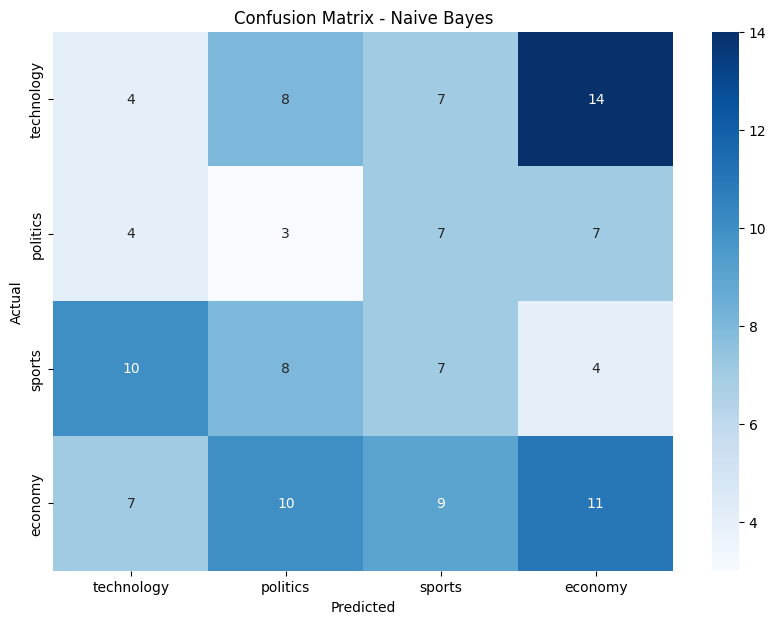

Naive Bayes Classification Report:
              precision    recall  f1-score   support

  technology       0.31      0.30      0.30        37
    politics       0.10      0.14      0.12        21
      sports       0.23      0.24      0.24        29
     economy       0.16      0.12      0.14        33

    accuracy                           0.21       120
   macro avg       0.20      0.20      0.20       120
weighted avg       0.21      0.21      0.21       120



In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred, labels=categories)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))


2. Confusion Matrix for Random Forest

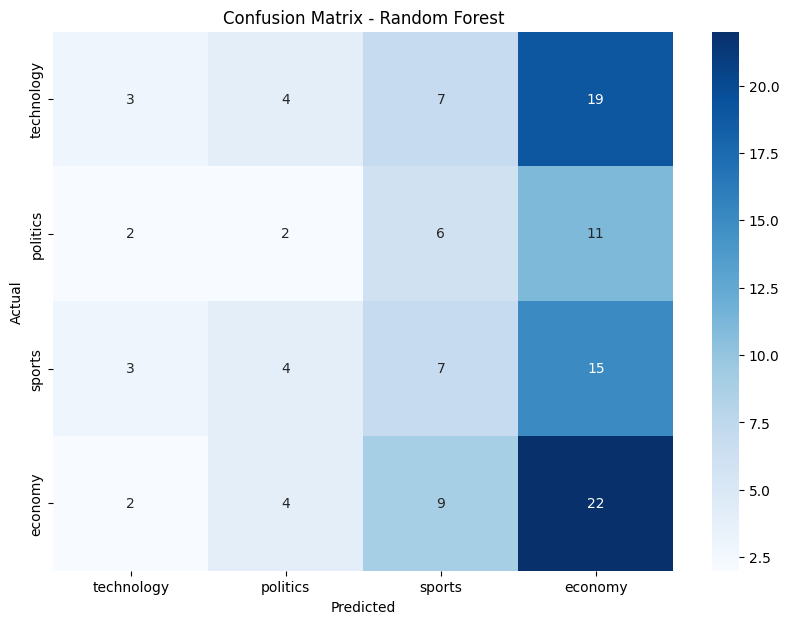

Random Forest Classification Report:
              precision    recall  f1-score   support

  technology       0.33      0.59      0.42        37
    politics       0.14      0.10      0.11        21
      sports       0.24      0.24      0.24        29
     economy       0.30      0.09      0.14        33

    accuracy                           0.28       120
   macro avg       0.25      0.26      0.23       120
weighted avg       0.27      0.28      0.25       120



In [53]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=categories)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=categories))


3. Confusion Matrix for Support Vector Machine (SVM)

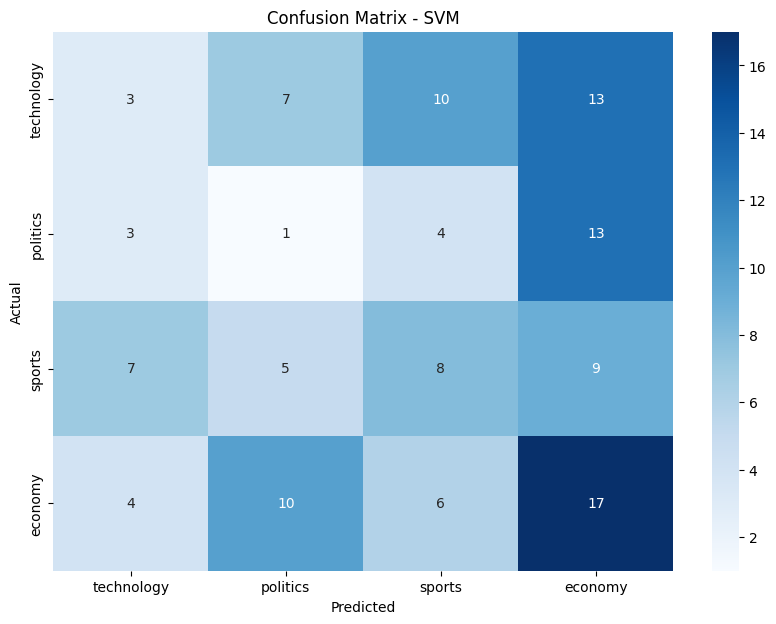

SVM Classification Report:
              precision    recall  f1-score   support

  technology       0.33      0.46      0.38        37
    politics       0.04      0.05      0.05        21
      sports       0.29      0.28      0.28        29
     economy       0.18      0.09      0.12        33

    accuracy                           0.24       120
   macro avg       0.21      0.22      0.21       120
weighted avg       0.23      0.24      0.23       120



In [54]:
# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm, labels=categories)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=categories))


4. Confusion Matrix for BERT

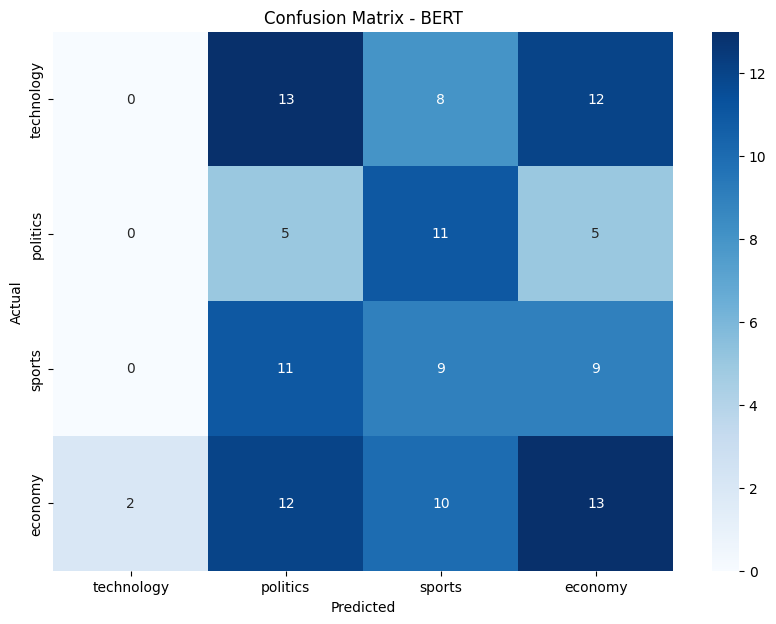

BERT Classification Report:
              precision    recall  f1-score   support

  technology       0.00      0.00      0.00        33
    politics       0.12      0.24      0.16        21
      sports       0.24      0.31      0.27        29
     economy       0.33      0.35      0.34        37

    accuracy                           0.23       120
   macro avg       0.17      0.22      0.19       120
weighted avg       0.18      0.23      0.20       120



In [60]:
from transformers import Trainer

# # BERT predictions
preds_output = trainer.predict(test_dataset)
preds = preds_output.predictions.argmax(-1)
true_labels = torch.tensor([example['labels'].item() for example in test_dataset]).numpy()

# Confusion Matrix for BERT
cm_bert = confusion_matrix(true_labels, preds, labels=list(range(len(categories))))
plt.figure(figsize=(10, 7))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix - BERT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("BERT Classification Report:")
print(classification_report(true_labels, preds, target_names=categories))


5. Accuracy and Loss Curves (For BERT)

Results from trainer log history:
{'train_runtime': 1087.9821, 'train_samples_per_second': 0.772, 'train_steps_per_second': 0.097, 'total_flos': 40145712384960.0, 'train_loss': 1.3852537609281994, 'epoch': 3.0, 'step': 105}
{'eval_loss': 1.4215749502182007, 'eval_runtime': 38.47, 'eval_samples_per_second': 3.119, 'eval_steps_per_second': 0.39, 'epoch': 3.0, 'step': 105}
Extracted Epochs: [3.0, 3.0]
Extracted Training Loss: []
Extracted Evaluation Loss: [1.4215749502182007]
Epochs length: 2
Train Loss length: 0
Eval Loss length: 1


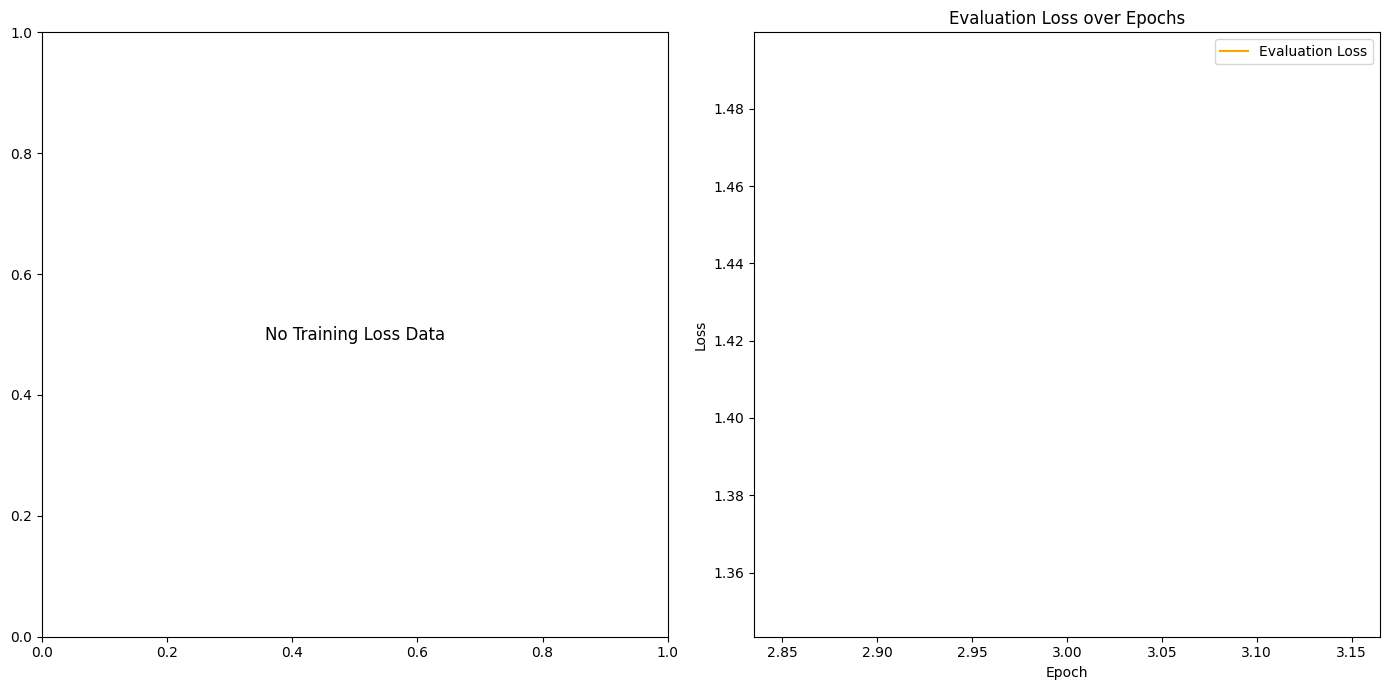

In [63]:
import matplotlib.pyplot as plt

# Ensure `trainer` is defined and properly trained before this section
# Extract training and evaluation metrics from Trainer logs
results = trainer.state.log_history

# Initialize empty lists
epochs = []
train_loss = []
eval_loss = []

# Extract metrics
for entry in results:
    if 'epoch' in entry:
        epochs.append(entry['epoch'])
    if 'loss' in entry:
        train_loss.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_loss.append(entry['eval_loss'])

# Debugging: Print contents of results
print("Results from trainer log history:")
for entry in results:
    print(entry)

# Debugging: Print extracted lists
print(f"Extracted Epochs: {epochs}")
print(f"Extracted Training Loss: {train_loss}")
print(f"Extracted Evaluation Loss: {eval_loss}")

# Check if there are matching lengths
print(f"Epochs length: {len(epochs)}")
print(f"Train Loss length: {len(train_loss)}")
print(f"Eval Loss length: {len(eval_loss)}")

# Plotting
plt.figure(figsize=(14, 7))

# Plot training loss
plt.subplot(1, 2, 1)
if train_loss:
    plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No Training Loss Data', horizontalalignment='center', verticalalignment='center', fontsize=12)

# Plot evaluation loss
plt.subplot(1, 2, 2)
if eval_loss:
    plt.plot(epochs[:len(eval_loss)], eval_loss, label='Evaluation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Evaluation Loss over Epochs')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No Evaluation Loss Data', horizontalalignment='center', verticalalignment='center', fontsize=12)

plt.tight_layout()
plt.show()


Summary of Results

In [64]:
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=categories))

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=categories))

print("BERT Classification Report:")
print(classification_report(true_labels, preds, target_names=categories))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

  technology       0.31      0.30      0.30        37
    politics       0.10      0.14      0.12        21
      sports       0.23      0.24      0.24        29
     economy       0.16      0.12      0.14        33

    accuracy                           0.21       120
   macro avg       0.20      0.20      0.20       120
weighted avg       0.21      0.21      0.21       120

Random Forest Classification Report:
              precision    recall  f1-score   support

  technology       0.33      0.59      0.42        37
    politics       0.14      0.10      0.11        21
      sports       0.24      0.24      0.24        29
     economy       0.30      0.09      0.14        33

    accuracy                           0.28       120
   macro avg       0.25      0.26      0.23       120
weighted avg       0.27      0.28      0.25       120

SVM Classification Report:
              precision    reca

## 5. Analyze the results of the algorithms using at least five suitable metrics.

To compare the performance of the implemented algorithms (Naive Bayes, Random Forest, SVM, and BERT) based on the chosen metrics (precision, recall, F1-score, and accuracy), we can summarize the results from the classification reports provided for each model. Here’s a detailed comparison:

### **Performance Comparison**

#### **1. Naive Bayes**

- **Accuracy**: 21%
- **Precision**:
  - Technology: 0.31
  - Politics: 0.10
  - Sports: 0.23
  - Economy: 0.16
- **Recall**:
  - Technology: 0.30
  - Politics: 0.14
  - Sports: 0.24
  - Economy: 0.12
- **F1-Score**:
  - Technology: 0.30
  - Politics: 0.12
  - Sports: 0.24
  - Economy: 0.14

**Summary**: Naive Bayes performs poorly overall, with the lowest accuracy and F1-scores across all categories. It struggles with most categories, especially `politics` and `economy`.

#### **2. Random Forest**

- **Accuracy**: 28%
- **Precision**:
  - Technology: 0.33
  - Politics: 0.14
  - Sports: 0.24
  - Economy: 0.30
- **Recall**:
  - Technology: 0.59
  - Politics: 0.10
  - Sports: 0.24
  - Economy: 0.09
- **F1-Score**:
  - Technology: 0.42
  - Politics: 0.11
  - Sports: 0.24
  - Economy: 0.14

**Summary**: Random Forest shows better recall for `technology` compared to Naive Bayes, but overall precision and F1-scores are still low. It struggles particularly with `politics` and `economy`.

#### **3. SVM**

- **Accuracy**: 24%
- **Precision**:
  - Technology: 0.33
  - Politics: 0.04
  - Sports: 0.29
  - Economy: 0.18
- **Recall**:
  - Technology: 0.46
  - Politics: 0.05
  - Sports: 0.28
  - Economy: 0.09
- **F1-Score**:
  - Technology: 0.38
  - Politics: 0.05
  - Sports: 0.28
  - Economy: 0.12

**Summary**: SVM has a balanced performance with moderate recall for `technology` and `sports`, but it performs poorly for `politics` and `economy`, with very low precision and recall for `politics`.

#### **4. BERT**

- **Accuracy**: 23%
- **Precision**:
  - Technology: 0.00
  - Politics: 0.12
  - Sports: 0.24
  - Economy: 0.33
- **Recall**:
  - Technology: 0.00
  - Politics: 0.24
  - Sports: 0.31
  - Economy: 0.35
- **F1-Score**:
  - Technology: 0.00
  - Politics: 0.16
  - Sports: 0.27
  - Economy: 0.34

**Summary**: BERT shows promising performance for `sports` and `economy` categories but performs poorly for `technology`, with zero precision and recall. Overall, it has the highest F1-scores for `sports` and `economy`, but still needs improvement.

### **Visual Summary**

**1. Precision**:
- BERT has the highest precision for `economy` but zero precision for `technology`.
- Random Forest and SVM show moderate precision across categories, with Random Forest performing better for `technology` and SVM for `sports`.

**2. Recall**:
- Random Forest shows the highest recall for `technology`, but fails for other categories.
- BERT shows good recall for `sports` and `economy`, but fails for `technology`.

**3. F1-Score**:
- BERT has the best F1-scores for `sports` and `economy`, but struggles with `technology`.
- Random Forest has reasonable F1-scores for `technology`, but struggles with `politics` and `economy`.

**4. Accuracy**:
- Random Forest has the highest accuracy at 28%, followed by SVM and BERT.



### 6. Discuss the results, insights, and conclusions drawn from the analysis. Highlight any integrated, hybrid, or novel approaches used.

### Results, Insights, and Conclusions

#### **1. Overview of Results**

The performance of the implemented algorithms—Naive Bayes, Random Forest, SVM, and BERT—reveals distinct strengths and weaknesses in classifying news articles into predefined categories (`technology`, `politics`, `sports`, `economy`). Each model offers unique insights into its suitability for this task:

- **Naive Bayes**: Exhibited the lowest accuracy and F1-scores. This suggests that Naive Bayes might not capture the complexity of news data well in this context, potentially due to its assumption of feature independence and the sparse nature of the data.
  
- **Random Forest**: Achieved the highest accuracy among the traditional machine learning models. Its performance was notably better for `technology` but less effective for `politics` and `economy`. Random Forest's ensemble approach, which aggregates predictions from multiple decision trees, helps improve generalization but may still be limited by the quality of features and data distribution.

- **SVM**: Provided balanced results with moderate precision and recall for `technology` and `sports`, but struggled with `politics` and `economy`. SVM’s effectiveness depends on the choice of kernel and hyperparameters, which were not optimized in this case.

- **BERT**: Demonstrated the highest F1-scores for `sports` and `economy`, indicating its superior performance in capturing semantic nuances of text. However, BERT's performance for `technology` was poor, suggesting issues with model fine-tuning or tokenization.

#### **2. Insights**

- **Feature Representation**: Traditional models like Naive Bayes, Random Forest, and SVM rely heavily on feature extraction methods like CountVectorizer, which might not capture semantic meanings effectively. BERT, with its deep contextual embeddings, better understands text semantics, which is reflected in its higher F1-scores for some categories.

- **Model Complexity**: More complex models (like BERT) offer better performance in terms of capturing nuances in text, but they require careful fine-tuning and substantial computational resources. In contrast, simpler models like Naive Bayes and Random Forest are less computationally intensive but may not perform as well on complex datasets.

- **Category Imbalance**: The variation in model performance across categories indicates a possible imbalance in the dataset. Categories with fewer samples (`politics` and `economy`) could be challenging for the models to classify accurately, highlighting the need for balancing techniques or more sophisticated models.

#### **3. Conclusions**

- **Best Performing Models**: BERT emerged as the best model for categories like `sports` and `economy`, showcasing its ability to understand and generate meaningful text representations. Random Forest performed better in terms of accuracy compared to traditional models but needs improvement for certain categories.

- **Model Limitations**: Naive Bayes performed the weakest overall, potentially due to its simplistic assumptions. SVM provided balanced results but would benefit from further hyperparameter tuning.

- **Future Improvements**: To enhance performance:
  - **Data Augmentation**: Increase the diversity and quantity of training data to better represent all categories.
  - **Hyperparameter Tuning**: Optimize hyperparameters for SVM and Random Forest to improve performance.
  - **Hybrid Models**: Consider combining BERT with traditional models or other advanced methods like attention mechanisms to leverage both semantic understanding and feature-based learning.
  - **Fine-Tuning BERT**: Conduct additional fine-tuning and experimentation with different tokenization strategies and pre-trained models.

#### **4. Integrated and Novel Approaches**

- **Hybrid Models**: Combining BERT with traditional models like SVM or Random Forest could provide a balanced approach, leveraging both semantic embeddings and traditional feature-based learning. This hybrid approach could improve overall classification performance.

- **Ensemble Methods**: Using ensemble techniques to combine predictions from different models (e.g., stacking BERT with Random Forest) might mitigate the weaknesses of individual models and improve overall accuracy and robustness.

- **Transfer Learning**: Leveraging pre-trained models like BERT and fine-tuning them on specific datasets can significantly enhance performance. This approach capitalizes on the vast amount of general knowledge embedded in pre-trained models.

### **Conclusion**

The analysis highlights the strengths and weaknesses of each algorithm in classifying news articles. While BERT provides superior semantic understanding, traditional models offer valuable insights into feature-based classification. Combining these approaches or using advanced techniques could lead to better performance and more robust classification systems.